## Часть 2

## Распознавание статических образов.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image

/home/prota/Neuroinformatics_labs/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Реализую слой Хопфилда.

In [2]:
class HopfieldLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(HopfieldLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.w1 = torch.nn.Parameter(torch.zeros((out_dim, out_dim)))
        self.b = torch.nn.Parameter(torch.zeros(out_dim))
        self.m = torch.zeros(out_dim)

    def forward(self, input):
        output = torch.matmul(input, self.w1)
        output = torch.add(output, self.b)
        output = torch.clamp(output, min=-1, max=1)
        self.m = output.detach().clone()
        
        return output

Загружу изображения цифр.

In [3]:
def load_image(path, width=320, height=240):
    image = Image.open(path)
    image = image.convert('RGB')  # удалить альфа канал, иногда он может присутствовать!
    image = image.resize((width, height), Image.ANTIALIAS)
    image = np.asarray(image, dtype=np.float32)
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)  # получить float32 вместо double
    image = (image - 127.5) / 127.5  # нормализовать [-1..1]
    image = 1 - image

    image = 2*image-1

    return image.flatten()

images = []
for i in range(3):
    images.append(load_image('num_pics/'+str(i)+'.png', 10, 10))

/tmp/ipykernel_2631/3651353932.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((width, height), Image.ANTIALIAS)


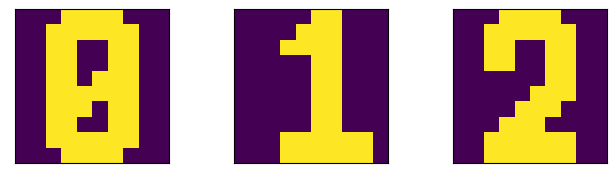

In [4]:
fig, ax = plt.subplots(1, len(images), figsize=(8, 2))

for i, image in enumerate(images):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(image.reshape(10, 10))

Построю и обучу сеть Хопфилда.

In [5]:
model = nn.Sequential(
    HopfieldLayer(100, 100)
)

optimizer = optim.Adam(model.parameters(), lr = 1e-4)
model.train()
None

In [6]:
epochs = 10
history = []

model.train()
for number_images in images[:3]:
    for i in range(epochs):
        losses = []

        output = model(torch.tensor(number_images))

        criterion = nn.MSELoss()
        loss = criterion(torch.tensor(number_images), output)
        losses += [loss.item()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        history += [np.mean(losses)]

Взгляну на значения весов.

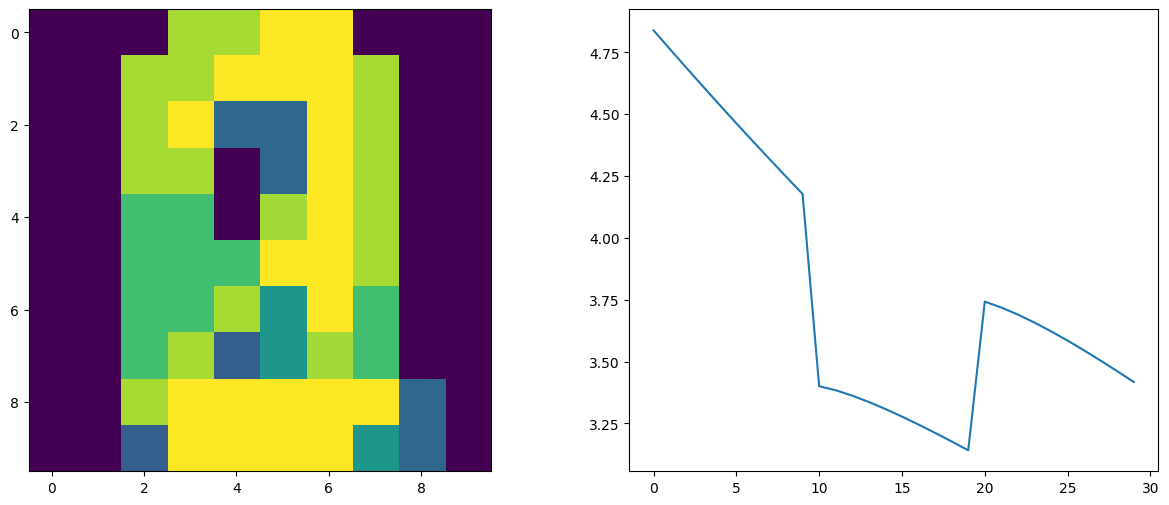

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(model[0].m.reshape(10, 10))
ax[1].plot(history)

plt.show()

Попробую восстановить зашумленные изображения.

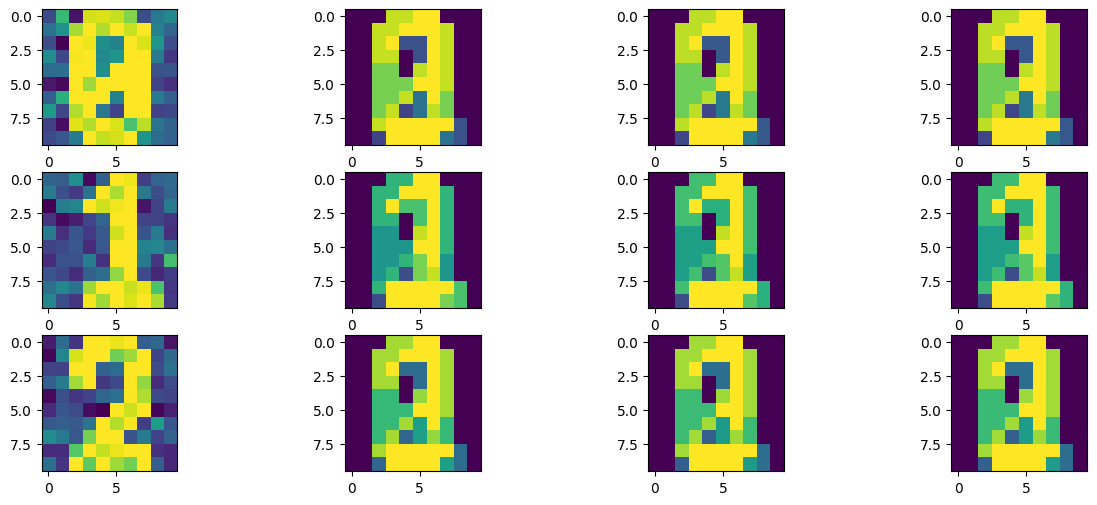

In [12]:
model.eval()

fig, ax = plt.subplots(len(images), 4, figsize=(15, 6))

for i, image in enumerate(images):
    init_output = torch.clamp(torch.tensor(image)*0.7 + torch.randn(image.shape) / 2, -2, 2) / 2
    ax[i, 0].imshow(init_output.detach().numpy().reshape(10, 10))
    output = init_output
    for j in range(1, 4):
        output += (0.5*init_output)
        output = model(output)
        ax[i, j].imshow(output.detach().numpy().reshape(10, 10))
    # ax[i, 1].imshow(output.detach().numpy().reshape(10, 10))

plt.show()

__Вывод__: В ходе выполнения лабораторной работы я реализовал рекуррентные сети Хопфилда и Элмана. Применил их для решения задач распознавания статических и динамических образов соответственно. Распознавание динамического образа в виде сигнала путем применения сети Элмана оказалось довольно эффективной. Однако, сеть Хопфилда, примененная для распознавания статических образов в виде изображений цифр, показала себя не слишком продуктивно. Кажется, что сеть сводит любое изображение к значениям своих весов.